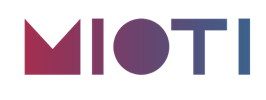
<center style="color:#888">Módulo Data Science in IoT<br/>Asignatura Machine Learning</center>
<center style="color:#aaa; margin-top:10px;">Prof. Diego García Morate<br>diegogm@faculty.mioti.es</center>


# Worksheet S7: Hiperparametrización y XGBoost

## Objetivos

Los objetivos de este worksheet son:
* que aprendas a hiperparametrizar algoritmos.
* que aprendas un nuevo algoritmo de clasificación XGBoost

## Prerrequisitos

Para hacer funcionar este worksheet deberás tener instalados los paquetes:

* `numpy`
* `pandas`
* `scikit-learn`
* `scipy`

Si utilizas Linux u OSx:

* `xgboost`

Si utilizas Windows deberás instalar:

* `py-xgboost`

## Configuración del entorno

In [7]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

También vamos a cargar algunas funciones que nos resultarán interesantes.

In [8]:
def dibuja_dataset(X, y):  
    from matplotlib.colors import ListedColormap
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    plt.scatter(X[:,0], X[:, 1], c=y, cmap=cm_bright, edgecolors='k')

## Dataset

Como en otras ocasiones vamos a generar un dataset ficticio:

In [9]:
from sklearn.datasets import make_moons
dataset_X, dataset_y = make_moons(noise=0.7, random_state=10)

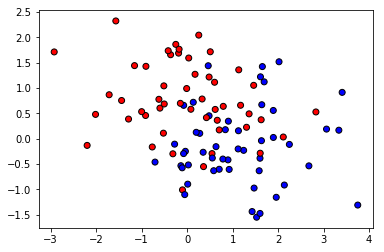

In [10]:
dibuja_dataset(dataset_X, dataset_y)

In [11]:
# Dividimos en conjunto de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(dataset_X, dataset_y, test_size=.3, random_state=42)

## Hiperparametrización

Como hemos visto, cada modelo dispone de un montón de parámetros que determinan el comportamiento de los algoritmos. Una buena o mala parametrización puede suponer la diferencia entre un buen clasificador o un mal clasificador.

Además sabemos que el nivel de complejidad del modelo tiene que ser capaz de ser suficiente para modelar la complejidad de los datos. Sin embargo, si generamos un modelo mucho más complejo que los datos podemos incurrir en el problema del sobreajuste:

<img src="complejidad_vs_sobreajuste.svg" width="70%">

### ¿Cómo encontrar ese punto ideal?

No existe una respuesta "mágica" para este tipo de preguntas, los métodos más habituales son probando distintas configuraciones y seleccionando la que mejor ajuste.

Cuando queremos modificar un sólo parámetro `sklearn` proporciona una función que nos permite dibujar una curva de validación que pone en correspondencia los valores obtenidos de entrenamiento y los test. Por defecto esta función internamente realiza una validación cruzada para separar entre conjunto de entrenamiento y test.

Podemos ver como se comporta con un modelo de KNN variando el número de vecinos:

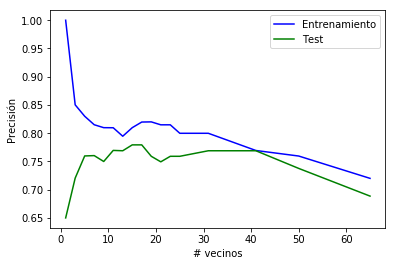

In [12]:
from sklearn.model_selection import validation_curve
from sklearn.neighbors import KNeighborsClassifier

k_vecinos = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 31, 41, 50, 65]

train_scores, test_scores = validation_curve(KNeighborsClassifier(), dataset_X, dataset_y, param_name='n_neighbors', param_range=k_vecinos)
plt.plot(k_vecinos, train_scores.mean(axis=1), 'b', label="Entrenamiento")
plt.plot(k_vecinos, test_scores.mean(axis=1), 'g', label="Test")
plt.ylabel('Precisión')
plt.xlabel('# vecinos')
plt.legend(loc="best");

Y variando el valor C en una SVM:

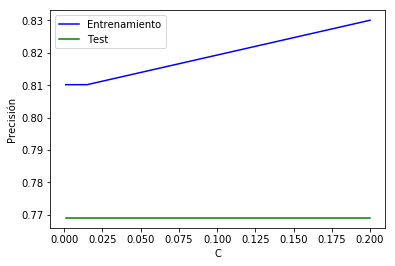

In [19]:
from sklearn.model_selection import validation_curve
from sklearn.svm import SVC

C_values = [0.001, 0.005, 0.01, 0.015, 0.2]

train_scores, test_scores = validation_curve(SVC(), dataset_X, dataset_y, param_name='C', param_range=C_values)
plt.plot(C_values, train_scores.mean(axis=1), 'b', label="Entrenamiento")
plt.plot(C_values, test_scores.mean(axis=1), 'g', label="Test")
plt.ylabel('Precisión')
plt.xlabel('C')
plt.legend(loc="best");

Si queremos modificar más de un parámetro a la vez deberemos construirnos nosotros el bucle de evaluación de los parámetros:

In [20]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

# Probamos la combinación de parámetros 
for kernel in ['linear', 'rbf', 'sigmoid']:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        scores = cross_val_score(SVC(kernel=kernel, C=C), dataset_X, dataset_y)
        print("Kernel: %8s\tC: %0.3f\tAccuracy: %.3f" % (kernel, C, np.mean(scores)))

Kernel:   linear	C: 0.001	Accuracy: 0.699
Kernel:   linear	C: 0.010	Accuracy: 0.749
Kernel:   linear	C: 0.100	Accuracy: 0.759
Kernel:   linear	C: 1.000	Accuracy: 0.710
Kernel:   linear	C: 10.000	Accuracy: 0.710
Kernel:   linear	C: 100.000	Accuracy: 0.710
Kernel:      rbf	C: 0.001	Accuracy: 0.769
Kernel:      rbf	C: 0.010	Accuracy: 0.769
Kernel:      rbf	C: 0.100	Accuracy: 0.769
Kernel:      rbf	C: 1.000	Accuracy: 0.759
Kernel:      rbf	C: 10.000	Accuracy: 0.730
Kernel:      rbf	C: 100.000	Accuracy: 0.749
Kernel:  sigmoid	C: 0.001	Accuracy: 0.768
Kernel:  sigmoid	C: 0.010	Accuracy: 0.768
Kernel:  sigmoid	C: 0.100	Accuracy: 0.769
Kernel:  sigmoid	C: 1.000	Accuracy: 0.750
Kernel:  sigmoid	C: 10.000	Accuracy: 0.659
Kernel:  sigmoid	C: 100.000	Accuracy: 0.649


### GridSearch

Alternativamente a implementarlo manualmente (que tiene sus ventajas e inconvenientes) `sklearn` proporciona funciones para hacer este tipo de cosas como la función `GridSearchCV`. Esta función realiza nuestro trabajo por nosotros y además provee funcionalidad adicional como cálculo en paralelo.

Como puedes ver su uso es bastante sencillo:

In [21]:
from sklearn.model_selection import GridSearchCV

params_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10], 
    'kernel': ['linear', 'rbf', 'sigmoid'], 
    'random_state': [42]
}

grid_svm = GridSearchCV(
    SVC(), 
    param_grid=params_grid, 
    n_jobs=4, 
    scoring='roc_auc'
)

Esta función es interesante por que es un *meta-estimador* es decir se utiliza exactamente igual que un estimador cualquiera:

In [22]:
grid_svm.fit(X_train, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['linear', 'rbf', 'sigmoid'], 'random_state': [42]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

Podemos consultar cual es el mejor resultado obtenido:

In [23]:
print(grid_svm.best_score_)

0.8512987012987013


Y con que parámetros:

In [24]:
print(grid_svm.best_params_)

{'C': 0.001, 'kernel': 'linear', 'random_state': 42}


Y podemos consultar con detalle todos las evaluaciones realizadas y los resultados obtenidos:

In [25]:
pd.DataFrame(grid_svm.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.002326,0.000898,0.023640,0.001073,0.001,linear,42,"{'C': 0.001, 'kernel': 'linear', 'random_state...",0.798611,0.969697,0.787879,0.851299,0.082941,1,0.876894,0.789855,0.876812,0.847854,0.041011
1,0.003393,0.000808,0.010175,0.012002,0.001,rbf,42,"{'C': 0.001, 'kernel': 'rbf', 'random_state': 42}",0.666667,0.946970,0.780303,0.796104,0.115346,10,0.899621,0.795290,0.836957,0.843956,0.042880
2,0.001617,0.000297,0.001692,0.000127,0.001,sigmoid,42,"{'C': 0.001, 'kernel': 'sigmoid', 'random_stat...",0.791667,0.954545,0.765152,0.836472,0.083309,5,0.873106,0.788043,0.876812,0.845987,0.041000
3,0.000724,0.000031,0.001561,0.000052,0.01,linear,42,"{'C': 0.01, 'kernel': 'linear', 'random_state'...",0.798611,0.969697,0.787879,0.851299,0.082941,1,0.875000,0.789855,0.876812,0.847222,0.040571
4,0.001038,0.000198,0.001720,0.000237,0.01,rbf,42,"{'C': 0.01, 'kernel': 'rbf', 'random_state': 42}",0.666667,0.946970,0.780303,0.796104,0.115346,10,0.897727,0.795290,0.836957,0.843325,0.042062


### RandomizedSearchCV

La función `GridSearchCV` realiza una búsqueda exhaustiva en el espacio de solución. Muchas veces debido a la explosión combinatoria al comnbinar parámetros esto no es posible. En estas situaciones lo que se suele hacer es realizar un muestro del espacio de soluciones. Para uno de los algoritmos más sencillos y utilizados es el muestreo aleatorio.

En `sklearn` lo podemos aplicar con la función `RandomizedSearchCV`, su uso es parecido a `GridSearchCV` con la principal diferencia de que en vez de proporcionar un diccionario con los posibles parámetros debemos proporcionar uno con las distribuciones de los parámetros. Para especificarlas es cómodo utilizar las funciones para especificar distribuciones que nos proporciona `scipy`:

In [26]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as st

params_dist = {
    'C': st.uniform(0.01, 10),
    'kernel': ['linear', 'rbf', 'sigmoid'], 
    'random_state': [42]
}

random_svm = RandomizedSearchCV(
    SVC(), 
    param_distributions=params_dist, 
    n_jobs=4, 
    n_iter=1000, 
    scoring='roc_auc', 
    random_state=42
)

In [27]:
random_svm.fit(X_train, y_train)

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
          fit_params=None, iid='warn', n_iter=1000, n_jobs=4,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1811e080>, 'kernel': ['linear', 'rbf', 'sigmoid'], 'random_state': [42]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=0)

In [28]:
print(random_svm.best_params_)

{'C': 0.012375235758845795, 'kernel': 'linear', 'random_state': 42}


In [29]:
print(random_svm.best_score_)

0.8512987012987013


### Errores al hiperparametrizar

Como hemos visto, la hiperparametrización es un mecanismo efectivo en muchos casos para mejorar el rendimiento de un modelo. Pero.. ¿cuando hiperparametrizamos no caemos en la posibilidad de ajustar demasiado los parámetros a un conjunto de entrenamiento?. ¿son los hiperparámetros parte o no del modelo?.

La respuesta es que sí, los hiperparámetros son también parte del modelo (quizás de orden distinto a los valores internos de los modelos en si).

Para evitar los errores de la hiperparametrización se suele realizar una validación de la hiperparametrización. Una estrategia de entrenamiento muy frecuente es la siguiente:

<img src="grid_search_cv.svg" width="90%">

Podemos aplicar esta estrategia de la siguiente manera:

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(dataset_X, dataset_y, test_size=.3, random_state=42)


# Ajustamos los hiperparámetros a analizar
params_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10], 
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'random_state': [42]
}

grid_svm = GridSearchCV(SVC(), param_grid=params_grid)

# Entrenamos el modelo
grid_svm.fit(X_train, y_train)

# Lo evaluamos
grid_svm.score(X_test, y_test)

0.7666666666666667

### Preguntas

* ¿Hiperparametrización si o no?
* ¿Qué riesgos incurrimos si hiperparametrizamos? ¿cómo podemos mitigarlos? 
* ¿Qué riesgos incurrimos si no hiperparametrizamos?

## XGBoost

XGBoost es una implementación de un algoritmo *gradient boosting trees* (GBT) que ha copado mucho interés en los últimos años porque gran parte de las competiciones de Kaggle se han ganado utilizado el mismo.

Este algoritmo se basa es una implementación muy eficiente de los GBTs de manera que son capaces de procesar datasets enormes de manera muy eficiente.

Las ideas base de los GBTs son parecidas a los *RandomForests*: realizar particiones de los datos por distintos criterios y en cada uno de ellos entrenar un árbol de decisión independiente. La combinación de clasificadores simples nos permite obtener clasificadores mucho más complejos (metaclasificadores).


La diferencia entre *GradientBoostingTrees* y los *RandomForests* se basa en que los segundos entrenan cada uno de los árboles de forma totalmente independiente sin embargo en los primeros el entrenamiento es en cascada. La idea clave es en cada iteración entrenar un árbol, analizar su desempeño e identificar las situaciones en las que no clasifica bien. En la siguiente etapa entrenaremos otro árbol que aprenda a clasificar mejor los errores del árbol anterior.

El entrenamiento (de forma simplificada) *fit* funcionaría de la siguiente manera:

<pre style="background-color:#eee; padding: 15px">
def fit(X, y):
    self.bosque = []
    for iteración in iteraciones:
        # Entrenamos el modelo con el dataset actual
        árbol = entrenar_árbol(X)
        self.bosque.append(árbol)
        
        # Nos quedamos sólo con los elementos mal clasificados
        X = árbol.estimar_elementos_mal_clasificados(X, y) 
</pre>

Y el paso de inferencia (*predict*) de la siguiente forma:

<pre style="background-color:#eee; padding: 15px">
def predict(X):
    y = None
    for árbol in self.bosque:
        # Evaluamos el árbol actual
        y = y + árbol.predict(X)
    return y
</pre>

### ¿Cómo utilizar xgboost?

Como podremos ver el uso de `xgboost` es bastante sencillo, disponiendo además una interfaz nativa para `sklearn`.

In [32]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' # Requerido para utilizar xgboost > 0.8.0 en Jupyter

from xgboost.sklearn import XGBClassifier  

model = XGBClassifier()

In [33]:
X_train, X_test, y_train, y_test = train_test_split(dataset_X, dataset_y, test_size=.3, random_state=42)

In [34]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Veamos cuales son sus parámetros principales:

* **max_depth**: representa la profundidad de los árboles a construir
* **n_estimators**: es el número de árboles a construir.
* **learning_rate**: Es la tasa de aprendizaje, a menor valor mayor número de árboles ya que el algoritmo iterará más veces hasta llegar a la convergencia.
* **subsample**: es el porcentaje de instancias con el que trabajará cada árbol (1 significa que todos los árboles evaluarán el 100% de instancias)
* **colsample_bytree**: Es el % de atributos que utilizará cada árbol.
* **objetive**: Es la función de pérdida, 'binary:logistic' es la que utilizaremos porque nos proporciona una probabilidad por cada clase objetivo.

In [35]:
model.predict(X_test)  

array([0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 0])

In [36]:
model.score(X_test, y_test)

0.8

Como vemos la interfaz es análoga a otros métodos.

También podemos hiperparametrizar este algoritmo como otros que hemos utilizado anteriormente:

In [37]:
params_dist = {  
    "n_estimators": st.randint(3, 40), # Genera valores aleatorios entre el valor minimo y máximo
    "max_depth": st.randint(3, 40), 
    "learning_rate": st.uniform(0.05, 0.4), 
    "colsample_bytree": st.uniform(0.7, 0.3), # Genera valores aleatorios con media - variancia
    "subsample": st.uniform(0.6, 0.4),
}

random_xgboost = RandomizedSearchCV(
    XGBClassifier(), 
    param_distributions=params_dist, 
    n_jobs=4, 
    n_iter=1000, 
    scoring='roc_auc', 
    random_state=42
)

In [38]:
random_xgboost.fit(X_train, y_train)

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=1000, n_jobs=4,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a181255f8>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a181132b0>, 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a181133c8>, 'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a18113668>, 'subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a18113fd0>},
     

In [39]:
print(random_xgboost.best_score_)

0.8344696969696971


In [40]:
random_xgboost.best_params_

{'colsample_bytree': 0.7382457040420738,
 'learning_rate': 0.37008253907343164,
 'max_depth': 14,
 'n_estimators': 24,
 'subsample': 0.6573125834810564}

In [41]:
random_xgboost.score(X_test, y_test)

0.8571428571428572